# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('filtered.pkl', 'rb') as handle:
    filtered = pickle.load(handle)
handle.close()

with open('filterednc.pkl', 'rb') as handle:
    filterednc = pickle.load(handle)
handle.close()

globalt0 = dt.datetime.now()

In [213]:
import statsmodels.api as sm

# Explore CV of interevent times

The idea is to pick a few alters that receive a high number of phone calls and check if the distribution for their intervent times show a particular distribution. The main goal is to use those distributions as a way to give a certainty that a relationship observed at the beginning of the data is actually a **new** relationship and not just a continuing one being observed due to the beginning of data. Same goes for the (observed) end of a relationship.

However, before doing this I need to get the pairs of ego alter and sort them by activity (total number of phone calls). As the first try, I'll use the filtered data including the cores

In [42]:
filt_pairs = {}
for c in filtered.keys():
    filt_pairs[c] = pc.pairs(filtered[c])
    filt_pairs[c].sort_values(by='nij', ascending=False, inplace=True)
    filt_pairs[c] = filt_pairs[c].loc[filt_pairs[c]['nij'] >= 3]

In [43]:
filt_pairs['uk']

,ego,alter,nij,k,n
554,C07817280467,C07816637861,1413,134,3873
150,C07800643466,C07800643415,1203,188,4429
2664,C07800643415,C07800643466,1062,90,1990
949,C07814508939,C07950483877,813,136,3261
579,C07817280467,C07973283191,727,134,3873
...,...,...,...,...,...
3579,C07800755987,C7814339501,3,91,1151
4620,C07890948782,C07757980532,3,55,297
36,C07800643466,C07849638750,3,188,4429
3372,C07970136770,C01142622640,3,177,1304


In [44]:
egos = [filt_pairs['uk2'].at[i, 'ego'] for i in list(filt_pairs['uk2'].index)[:100]]
alters = [filt_pairs['uk2'].at[i, 'alter'] for i in list(filt_pairs['uk2'].index)[:100]]

In [45]:
df = filtered['uk'].loc[(filtered['uk']['ego'] == egos[0]) & (filtered['uk']['alter'] == alters[0])]
df

,ego,alter,time,uclock,aclock,rm
1533,C07814508939,C07950483877,2007-12-02 21:05:00,272,0,0.0
1534,C07814508939,C07950483877,2007-12-04 09:28:00,273,1,0.0
1535,C07814508939,C07950483877,2007-12-04 14:16:00,274,2,0.0
1536,C07814508939,C07950483877,2007-12-04 18:14:00,274,2,0.0
1537,C07814508939,C07950483877,2007-12-04 18:22:00,274,2,0.0
...,...,...,...,...,...,...
2341,C07814508939,C07950483877,2008-06-19 13:19:00,472,200,0.0
2342,C07814508939,C07950483877,2008-06-19 22:05:00,472,200,0.0
2343,C07814508939,C07950483877,2008-06-19 22:11:00,472,200,0.0
2344,C07814508939,C07950483877,2008-06-19 23:10:00,472,200,0.0


In [46]:
df['ie'] = df['aclock'].diff()
df

<ipython-input-46-7bb031b5eaac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


,ego,alter,time,uclock,aclock,rm,ie
1533,C07814508939,C07950483877,2007-12-02 21:05:00,272,0,0.0,NaN
1534,C07814508939,C07950483877,2007-12-04 09:28:00,273,1,0.0,1.0
1535,C07814508939,C07950483877,2007-12-04 14:16:00,274,2,0.0,1.0
1536,C07814508939,C07950483877,2007-12-04 18:14:00,274,2,0.0,0.0
1537,C07814508939,C07950483877,2007-12-04 18:22:00,274,2,0.0,0.0
...,...,...,...,...,...,...,...
2341,C07814508939,C07950483877,2008-06-19 13:19:00,472,200,0.0,1.0
2342,C07814508939,C07950483877,2008-06-19 22:05:00,472,200,0.0,0.0
2343,C07814508939,C07950483877,2008-06-19 22:11:00,472,200,0.0,0.0
2344,C07814508939,C07950483877,2008-06-19 23:10:00,472,200,0.0,0.0


0.24630541871921183 0.5045835675783991


(array([634.,   0., 161.,   0.,   0.,  13.,   0.,   3.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

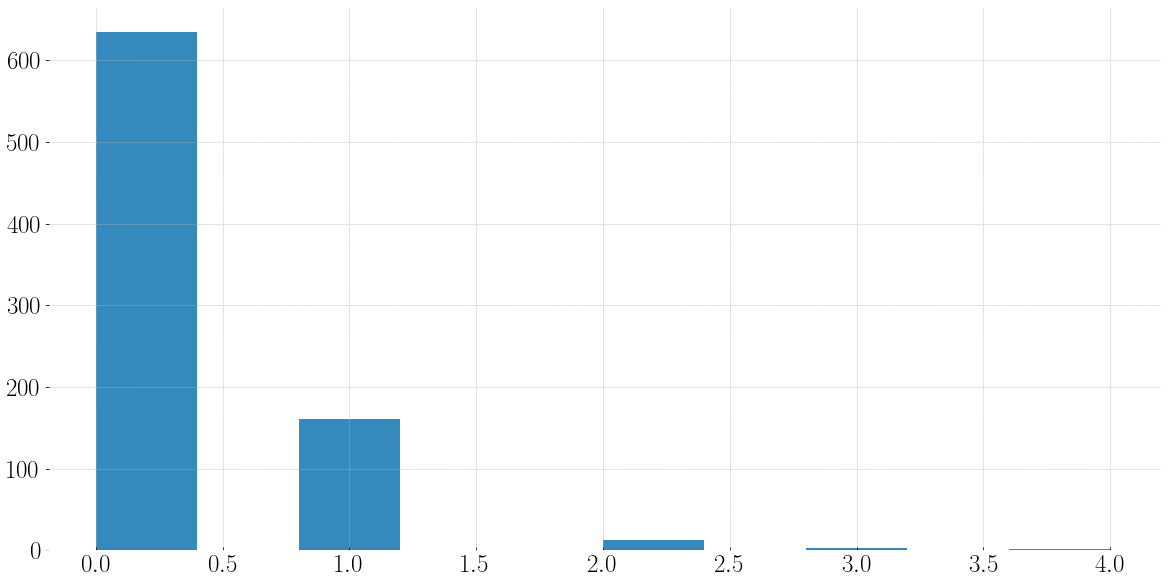

In [47]:
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.hist(df['ie'])

0.27548209366391185 0.7668255745608484


<ipython-input-102-e570bed42024>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


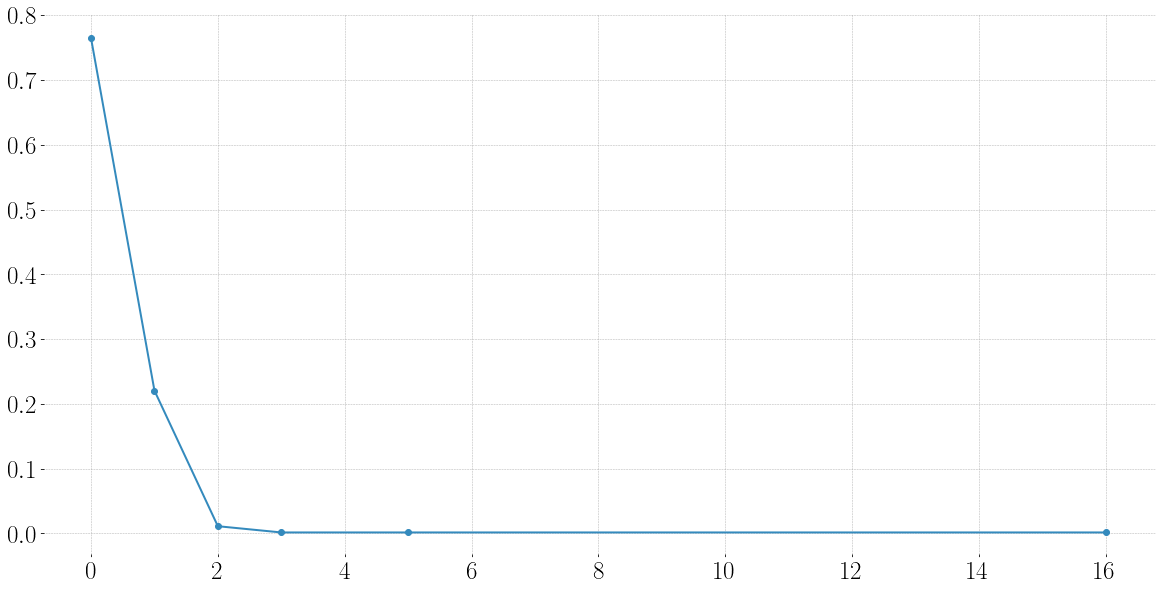

In [102]:
df = filtered['uk2'].loc[(filtered['uk2']['ego'] == egos[1]) & (filtered['uk2']['alter'] == alters[1])]
df['ie'] = df['aclock'].diff()
H = {}
for i in list(df['ie'])[1:]:
    H[i] = H.get(i, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.plot(H.index, H[0] / sum(H[0]), "o-")

3.7358490566037736 11.04391054509948


<ipython-input-101-f25eb563ef48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ie'] = df['aclock'].diff()


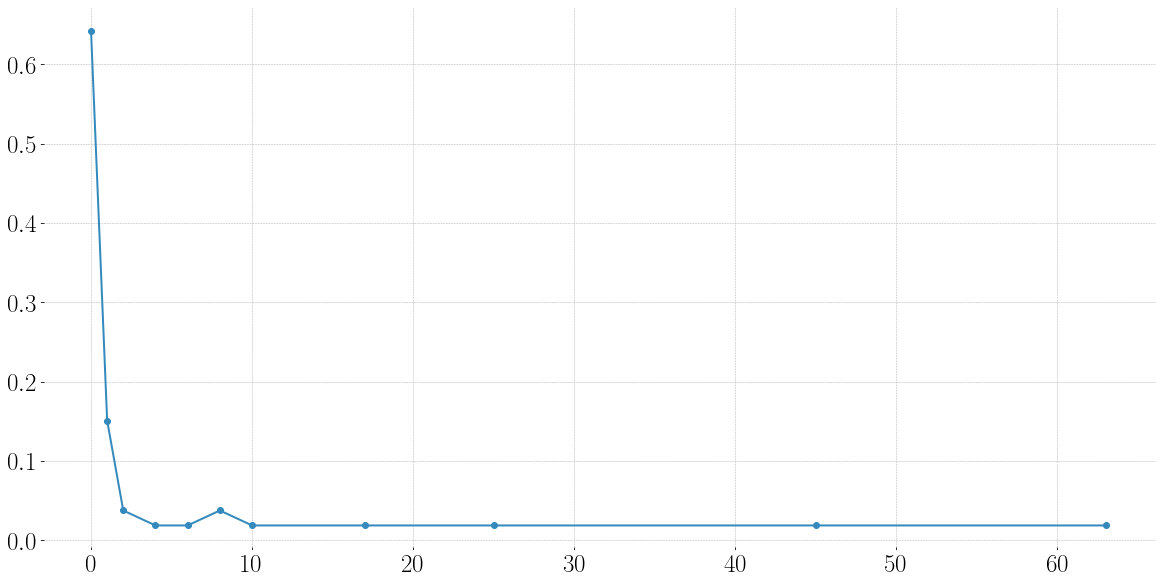

In [101]:
df = filtered['uk2'].loc[(filtered['uk2']['ego'] == egos[70]) & (filtered['uk2']['alter'] == alters[70])]
df['ie'] = df['aclock'].diff()
H = {}
for i in list(df['ie'])[1:]:
    H[i] = H.get(i, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
print(np.mean(list(df['ie'])[1:]), np.std(list(df['ie'])[1:]))
plt.plot(H.index, H[0] / sum(H[0]), "o-")

In [50]:
t0 = dt.datetime.now()
for c in filt_pairs.keys():
    df = filt_pairs[c]
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        df1 = filtered[c].loc[(filtered[c]['ego'] == ego) & (filtered[c]['alter'] == alter)]
        df1['ie'] = df1['aclock'].diff()
        ie_mean = np.mean(list(df1['ie'])[1:])
        ie_std = np.std(list(df1['ie'])[1:])
        filt_pairs[c].at[i, 'ie_mean'] = ie_mean
        filt_pairs[c].at[i, 'ie_std'] = ie_std
print(f'This block took {dt.datetime.now() - t0}')

<ipython-input-50-5dd38893406d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ie'] = df1['aclock'].diff()


This block took 0:01:40.489086


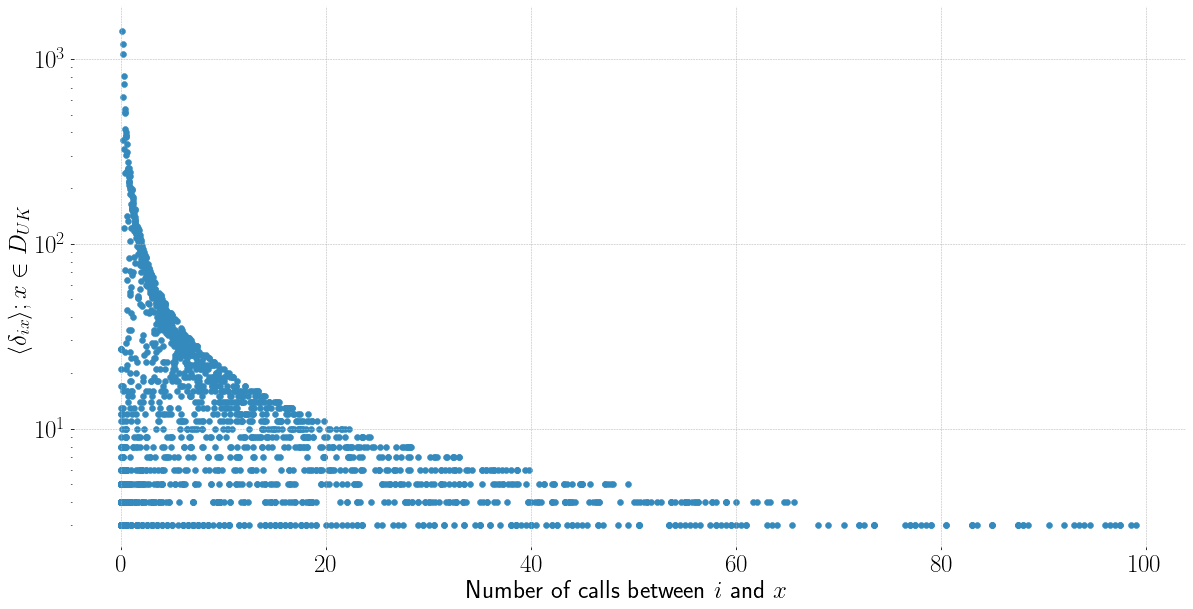

In [51]:
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk']['ie_mean'], filt_pairs['uk']['nij'])

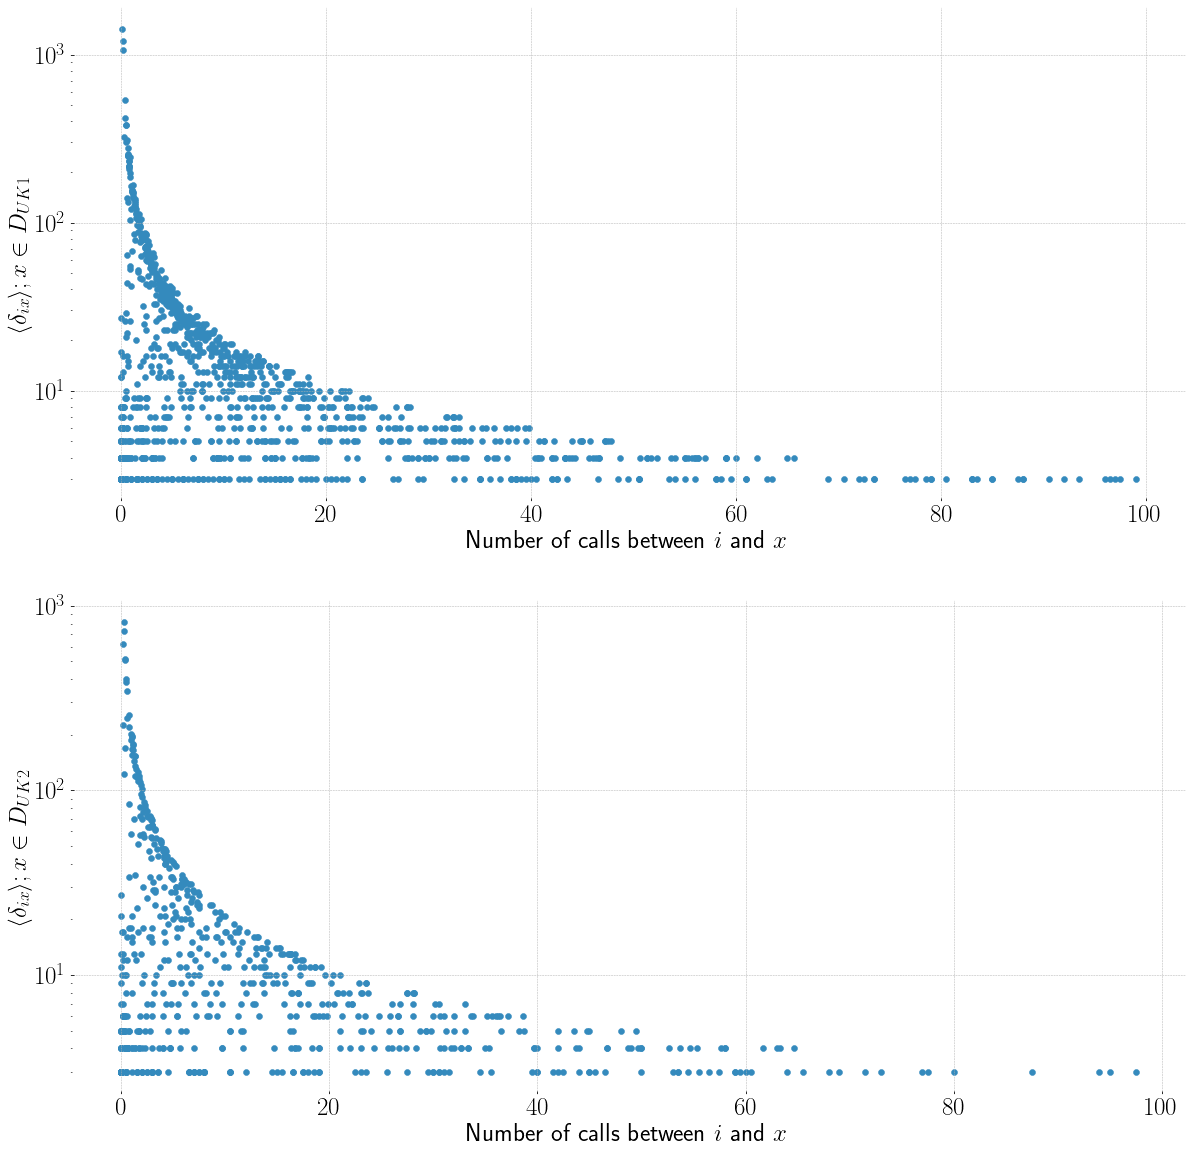

In [55]:
plt.figure(figsize=(20, 20))

plt.subplot(211)
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK1}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk1']['ie_mean'], filt_pairs['uk1']['nij'])

plt.subplot(212)
plt.ylabel(r'$\langle \delta_{ix} \rangle; x \in D_{UK2}$')
plt.xlabel(r'Number of calls between $i$ and $x$')
plt.semilogy()
plt.scatter(filt_pairs['uk2']['ie_mean'], filt_pairs['uk2']['nij'])

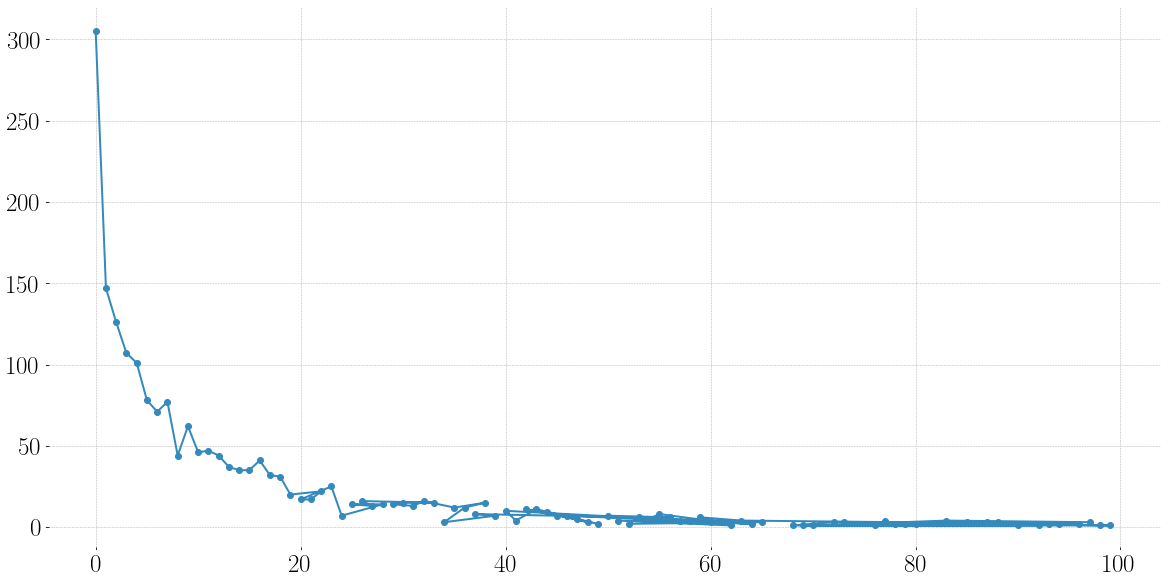

In [68]:
H = {}
for i in filt_pairs['uk']['ie_mean']:
    x = int(i)
    H[x] = H.get(x, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index')
plt.plot(H.index, H[0], "o-")

(array([101., 120., 159., 204., 229., 243., 213., 182., 133.,  55.]),
 array([0.        , 0.45951199, 0.91902397, 1.37853596, 1.83804794,
        2.29755993, 2.75707191, 3.2165839 , 3.67609588, 4.13560787,
        4.59511985]),
 <BarContainer object of 10 artists>)

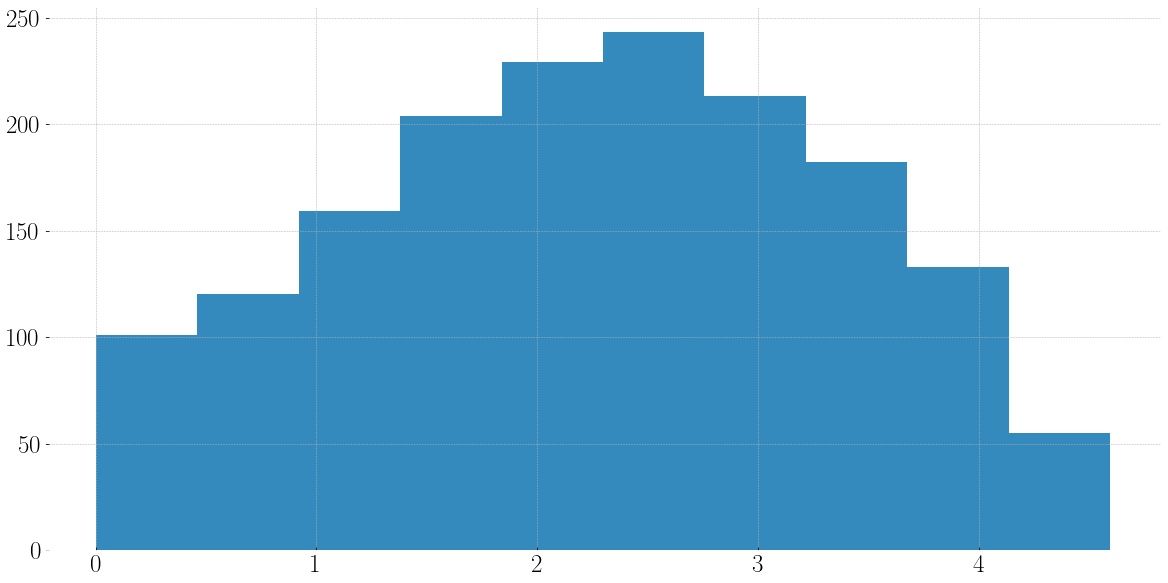

In [75]:
df = filt_pairs['uk'].loc[filt_pairs['uk']['ie_mean'] >= 1]
Y = np.log(df['ie_mean'])
plt.hist(Y)

## Asuming log-normal distribution

In [77]:
filt_pairs['uk'].head()

,ego,alter,nij,k,n,ie_mean,ie_std
554,C07817280467,C07816637861,1413,134,3873,0.122521,0.674192
150,C07800643466,C07800643415,1203,188,4429,0.133111,0.996960
2664,C07800643415,C07800643466,1062,90,1990,0.160226,0.678720
949,C07814508939,C07950483877,813,136,3261,0.246305,0.504584
579,C07817280467,C07973283191,727,134,3873,0.275482,0.765027


Looking at the pair of ego alter in the first row

In [78]:
df = filtered['uk'].loc[(filtered['uk']['ego'] == 'C07817280467') & (filtered['uk']['alter'] == 'C07816637861')]

In [79]:
df.head()

,ego,alter,time,uclock,aclock,rm
44316,C07817280467,C07816637861,2007-04-04 19:31:00,30,0,1.0
44317,C07817280467,C07816637861,2007-04-17 14:17:00,43,13,1.0
44318,C07817280467,C07816637861,2007-04-17 14:17:00,43,13,1.0
44319,C07817280467,C07816637861,2007-04-17 16:58:00,43,13,1.0
44320,C07817280467,C07816637861,2007-04-17 17:13:00,43,13,1.0


In [127]:
for c in filt_pairs.keys():
    df = filt_pairs[c]
    for i in df.index:
        df.at[i, 'p-new'] = stats.lognorm.sf(7, s=df.at[i, 'ie_std'], loc = df.at[i, 'ie_mean'])

In [128]:
for c in filt_pairs.keys():
    df = filt_pairs[c]
    new = 0
    for i in df.index:
        if df.at[i, 'p-new'] < 0.1:
            new += 1
    print(f'{c}: {new} new relationships detected, of a total of {len(df)}. Using 10%')

mit: 313 new relationships detected, of a total of 3047. Using 10%
uk1: 76 new relationships detected, of a total of 1163. Using 10%
uk2: 62 new relationships detected, of a total of 690. Using 10%
uk: 146 new relationships detected, of a total of 1944. Using 10%
all: 565 new relationships detected, of a total of 5747. Using 10%


# Identify *communication seasons*

In [144]:
filt_pairs['uk'].tail(1000)

,ego,alter,nij,k,n,ie_mean,ie_std,p-new
3130,C07974937643,C01142668510,8,170,1368,10.714286,18.606560,1.000000
2282,C07792057901,C01142662662,8,154,2210,17.428571,18.607657,1.000000
2109,C07999103487,C07825647691,8,495,2589,17.000000,27.650885,1.000000
557,C07817280467,C07806784520,8,134,3873,27.571429,64.692365,1.000000
3325,C07970136770,C07889859019,8,177,1304,6.142857,9.731078,0.506319
...,...,...,...,...,...,...,...,...
3579,C07800755987,C7814339501,3,91,1151,14.500000,14.500000,1.000000
4620,C07890948782,C07757980532,3,55,297,38.000000,38.000000,1.000000
36,C07800643466,C07849638750,3,188,4429,2.500000,1.500000,0.157998
3372,C07970136770,C01142622640,3,177,1304,96.000000,81.000000,1.000000


In [132]:
df = filtered['uk']
df1 = df.loc[(df['ego'] == 'C07817280467') & (df['alter'] == 'C07816637861')]

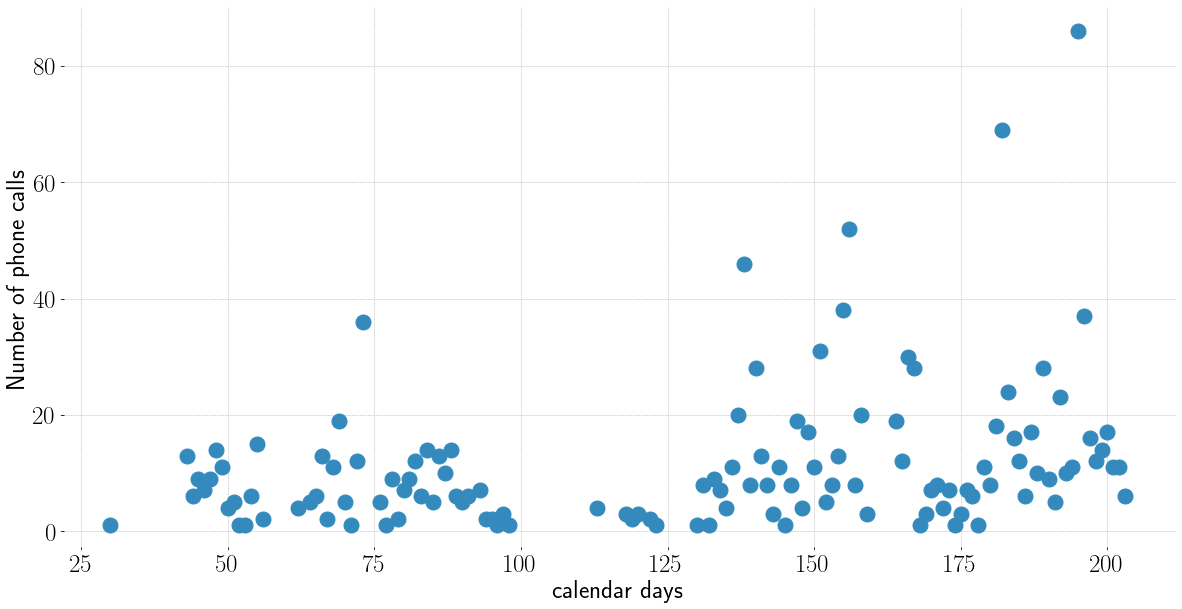

In [136]:
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

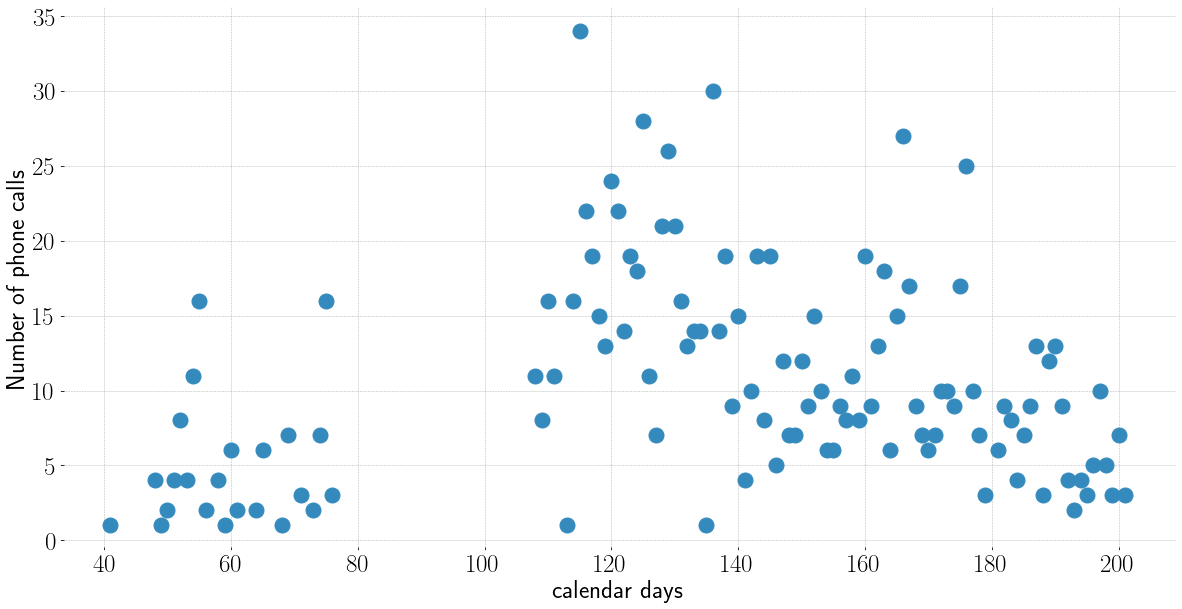

In [138]:
df1 = df.loc[(df['ego'] == 'C07800643466') & (df['alter'] == 'C07800643415')]
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

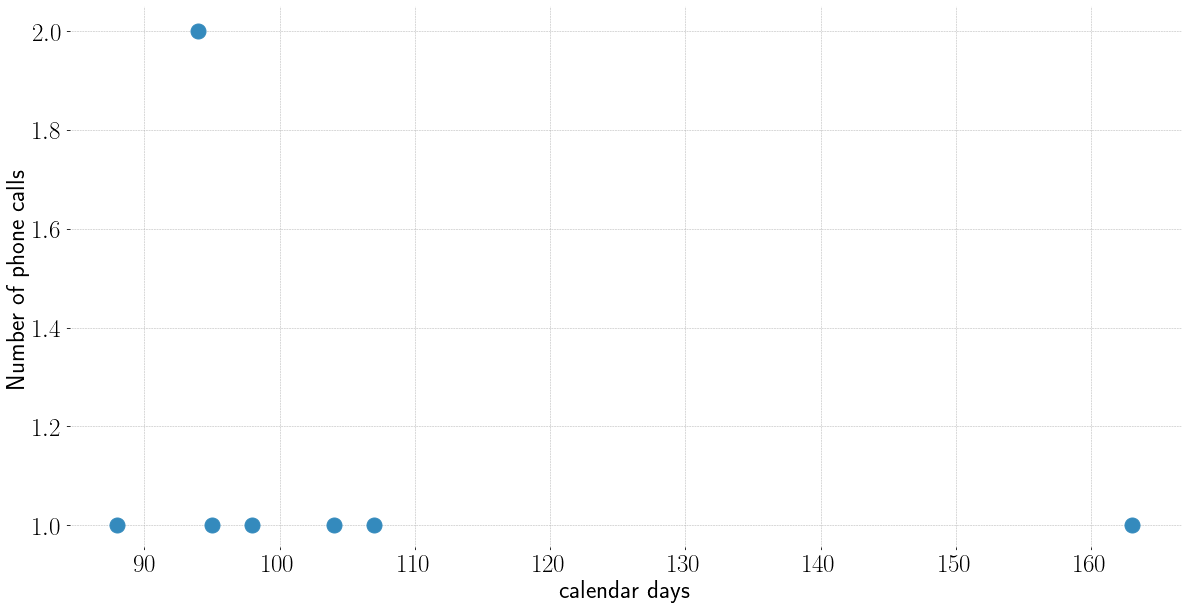

In [145]:
df1 = df.loc[(df['ego'] == 'C07974937643') & (df['alter'] == 'C01142668510')]
H = {}
for d in df1['uclock']:
    df2 = df1.loc[df1['uclock'] == d]
    H[d] = len(df2)
H = pd.DataFrame.from_dict(H, orient='index')

plt.xlabel("calendar days")
plt.ylabel("Number of phone calls")
plt.plot(H.index, H[0], "o", markersize=15)

In [147]:
t0 = dt.datetime.now()
seasons = {}
for c in filt_pairs.keys():
    df = filt_pairs[c]
    dfres = pd.DataFrame()
    idx = 0
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        df1 = filtered[c].loc[(filtered[c]['ego'] == ego) & (filtered[c]['alter'] == alter)]
        alldays = list(df1['uclock'].unique())
        mint = min(alldays)
        maxt = max(alldays)
        start_season = []
        for d in range(mint + 1, maxt):
            if (d - 1 not in alldays) and (d in alldays) and (d + 1 in alldays):
                start_season.append(d)
        dfres.at[idx, 'ego'] = ego
        dfres.at[idx, 'alter'] = alter
        dfres.at[idx, 'n_seasons'] = len(start_season)
        #dfres.at[idx, 'start_season'] = start_season
        idx += 1
    seasons[c] = dfres
print(f'Took {dt.datetime.now() - t0}')

Took 0:01:48.671386


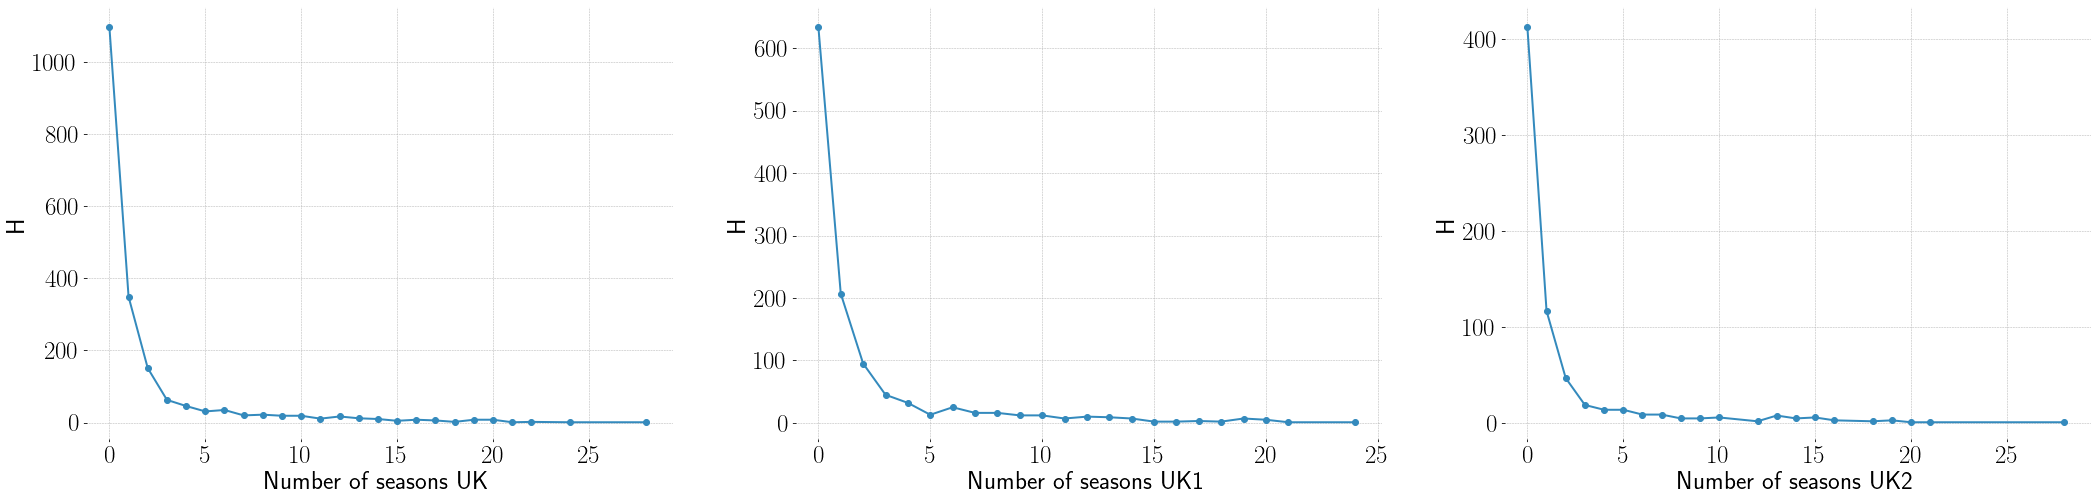

In [150]:
plt.figure(figsize=(36, 8))

plt.subplot(131)
plt.xlabel("Number of seasons UK")
plt.ylabel("H")
H = {}
for s in seasons['uk']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

plt.subplot(132)
plt.xlabel("Number of seasons UK1")
plt.ylabel("H")
H = {}
for s in seasons['uk1']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

plt.subplot(133)
plt.xlabel("Number of seasons UK2")
plt.ylabel("H")
H = {}
for s in seasons['uk2']['n_seasons']:
    H[s] = H.get(s, 0) + 1
H = pd.DataFrame.from_dict(H, orient='index').sort_index()
plt.plot(H.index, H[0], "o-")

,0
0.0,413
1.0,117
2.0,47
3.0,19
4.0,14
5.0,14
6.0,9
7.0,9
8.0,5
9.0,5


In [148]:
def get_temp_hist(df, ego, alter):
    df1 = df.loc[(df['ego'] == ego) & (df['alter'] == alter)]
    H = {}
    for d in df1['uclock']:
        df2 = df1.loc[df1['uclock'] == d]
        H[d] = len(df2)
    H = pd.DataFrame.from_dict(H, orient='index').sort_index()
    return H

# Max number of days without communication

I'll take this measurement for every ego. I'll get the distribution of the maximum number of days without communication between ego and all of its alters

In [168]:
filt_pairs['uk'].sort_values(by='k', ascending=False, inplace=True)

In [169]:
filt_pairs['uk'].head()

,ego,alter,nij,k,n,ie_mean,ie_std,p-new
1450,C07800759255,C01142253731,8,497,2730,23.714286,17.185661,1.000000
1471,C07800759255,C07796835479,14,497,2730,2.153846,6.904248,0.409597
1481,C07800759255,C07854475855,5,497,2730,13.250000,13.645054,1.000000
1414,C07800759255,C01142074267,5,497,2730,14.750000,22.219080,1.000000
1488,C07800759255,C07875703295,15,497,2730,11.714286,24.028045,1.000000


In [170]:
anego = filt_pairs['uk'].at[1450, 'ego']
analter = filt_pairs['uk'].at[1450, 'alter']
testdf = filtered['uk'].loc[(filtered['uk']['ego'] == anego) & (filtered['uk']['alter'] == analter)]
testdf.head()

,ego,alter,time,uclock,aclock,rm
19446,C07800759255,C01142253731,2007-12-20 08:47:00,289,0,0.0
19447,C07800759255,C01142253731,2007-12-20 09:12:00,289,0,0.0
19448,C07800759255,C01142253731,2008-01-18 14:38:00,319,30,0.0
19449,C07800759255,C01142253731,2008-02-20 09:32:00,351,62,0.0
19450,C07800759255,C01142253731,2008-02-22 11:07:00,353,64,0.0


In [159]:
testdf['ie'] = testdf['uclock'].diff()
testdf.head()

<ipython-input-159-0e02fd385405>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['ie'] = testdf['uclock'].diff()


,ego,alter,time,uclock,aclock,rm,ie
44316,C07817280467,C07816637861,2007-04-04 19:31:00,30,0,1.0,NaN
44317,C07817280467,C07816637861,2007-04-17 14:17:00,43,13,1.0,13.0
44318,C07817280467,C07816637861,2007-04-17 14:17:00,43,13,1.0,0.0
44319,C07817280467,C07816637861,2007-04-17 16:58:00,43,13,1.0,0.0
44320,C07817280467,C07816637861,2007-04-17 17:13:00,43,13,1.0,0.0


In [161]:
max(list(testdf['ie'])[1:])

15.0

In [186]:
t0 = dt.datetime.now()
nocommmax = {}
for c in filtered.keys():
    nocommmax[c] = {}
    df = filtered[c]
    for ego in df['ego'].unique():
        nocommmax[c][ego] = []
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            if len(df2) > 2:
                df2['ie'] = df2['aclock'].diff()
                nocommmax[c][ego].append(max(list(df2['ie'])[1:]))
                idx = list(filt_pairs[c].loc[(filt_pairs[c]['ego'] == ego) & (filt_pairs[c]['alter'] == alter)].index)[0]
                filt_pairs[c].at[idx, 'ie_max'] = nocommmax[c][ego][-1]
        H = {}
        for i in nocommmax[c][ego]:
            d = i // 10
            H[d] = H.get(d, 0) + 1
        H = pd.DataFrame.from_dict(H, orient='index').sort_index()
        nocommmax[c][ego] = H
print(f'Took {dt.datetime.now() - t0}')

<ipython-input-186-de3abf289c27>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ie'] = df2['aclock'].diff()


Took 0:00:22.469230


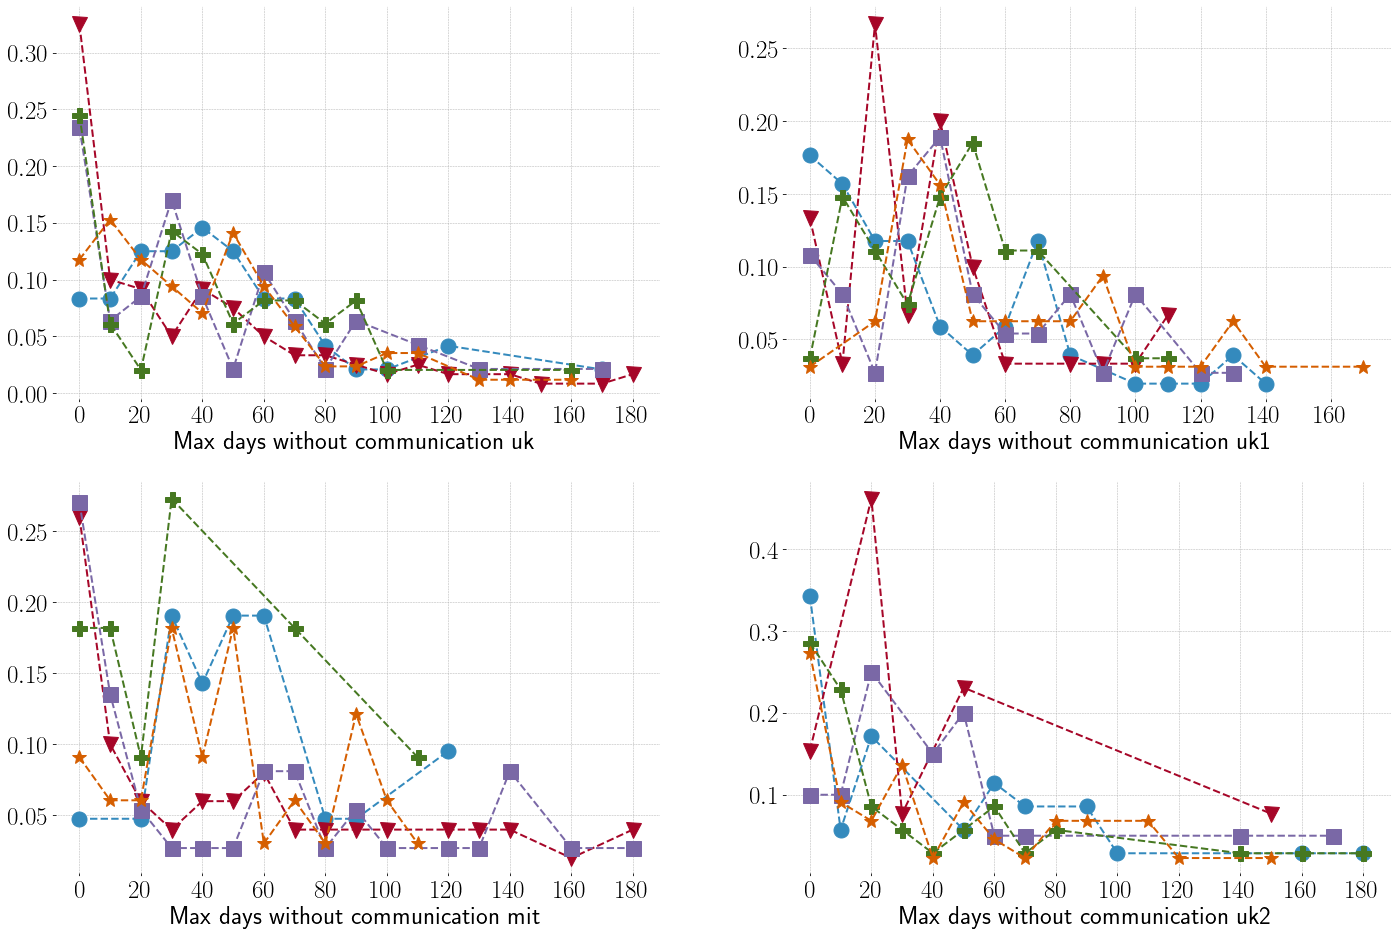

In [181]:
plt.figure(figsize=(24, 16))
p = 1
for c in ['uk', 'uk1', 'mit', 'uk2']:
    plt.subplot(2,2,p)
    plt.xlabel(f"Max days without communication {c}")
    plt.xticks(range(0, 200, 20))
    egos = list(nocommmax[c].keys())
    sample = np.random.choice(egos, size=5)
    for e in range(len(sample)):
        df = nocommmax[c][sample[e]]
        plt.plot([x * 10 for x in df.index], df[0]/sum(df[0]), marker=markers[e], markersize=15, ls="--")
    p += 1

In [188]:
t0 = dt.datetime.now()
scatters = {}
for c in filt_pairs.keys():
    scatters[c] = []
    df = filt_pairs[c]
    lives = pc.lives_dictionary(unfiltered[c])
    for i in df.index:
        ego = df.at[i, 'ego']
        alter = df.at[i, 'alter']
        ell = lives[ego][alter]['ell']
        iemax = df.at[i, 'ie_max']
        scatters[c].append((iemax, ell))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.582530


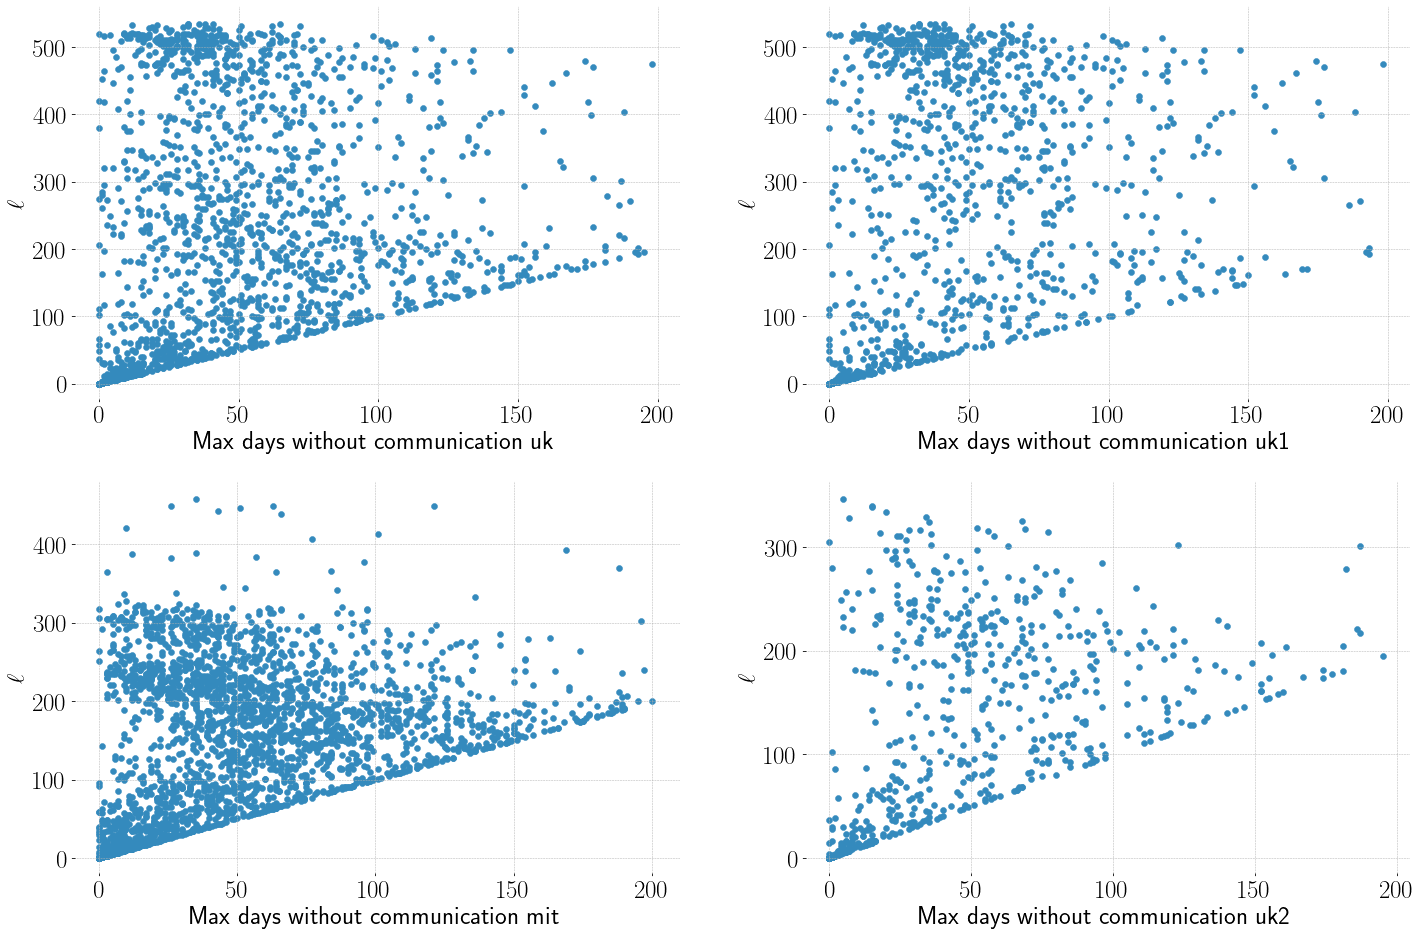

In [190]:
plt.figure(figsize=(24, 16))
p = 1
for c in ['uk', 'uk1', 'mit', 'uk2']:
    plt.subplot(2,2,p)
    plt.xlabel(f'Max days without communication {c}')
    plt.ylabel(r'$\ell$')
    plt.scatter([x[0] for x in scatters[c]], [y[1] for y in scatters[c]])
    p += 1

## Combining all alters (from all egos)

The idea is to create a single curve for all alters, one curve per cohort

In [201]:
maxieall = {}
for c in ['uk', 'mit']:
    H = {}
    df = filt_pairs[c]
    for d in df['ie_max']:
        H[d] = H.get(d, 0) + 1
    maxieall[c] = pd.DataFrame.from_dict(H, orient='index').sort_index()

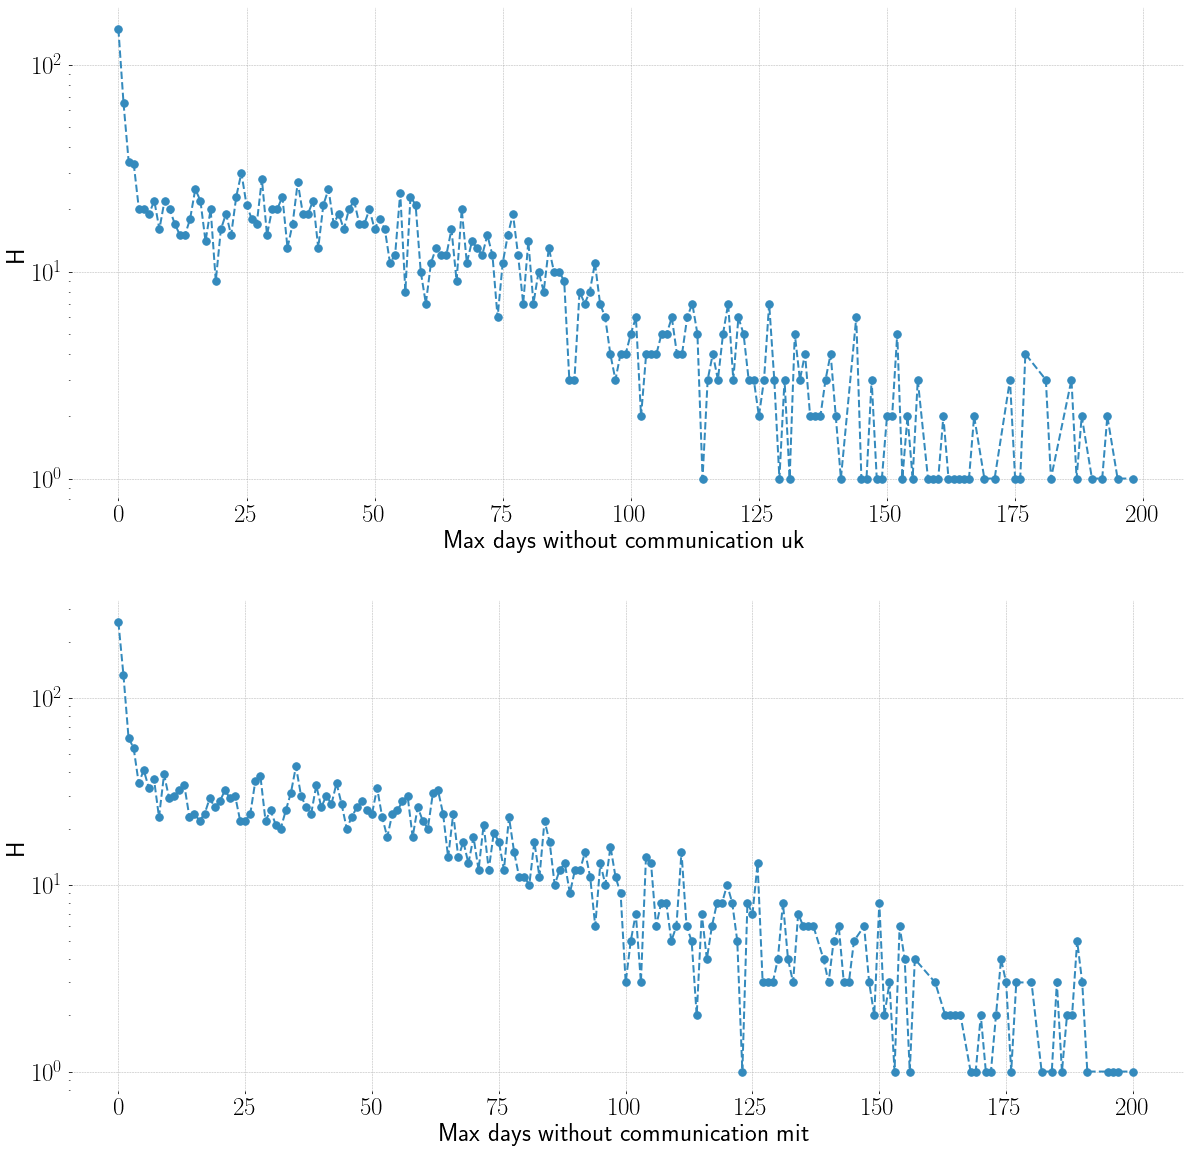

In [198]:
plt.figure(figsize=(20, 20))
p = 1
for c in maxieall.keys():
    plt.subplot(2, 1, p)
    plt.xlabel(f"Max days without communication {c}")
    plt.ylabel("H")
    plt.semilogy()
    plt.plot(maxieall[c].index, maxieall[c][0], ".", markersize=15, ls="--")
    p += 1

In [202]:
for c in maxieall.keys():
    df = maxieall[c]
    df['pdf'] = df[0] / sum(df[0])
    df['cdf'] = df['pdf'].cumsum()

In [205]:
for p in range(4):
    print(p % 2)

0
1
0
1


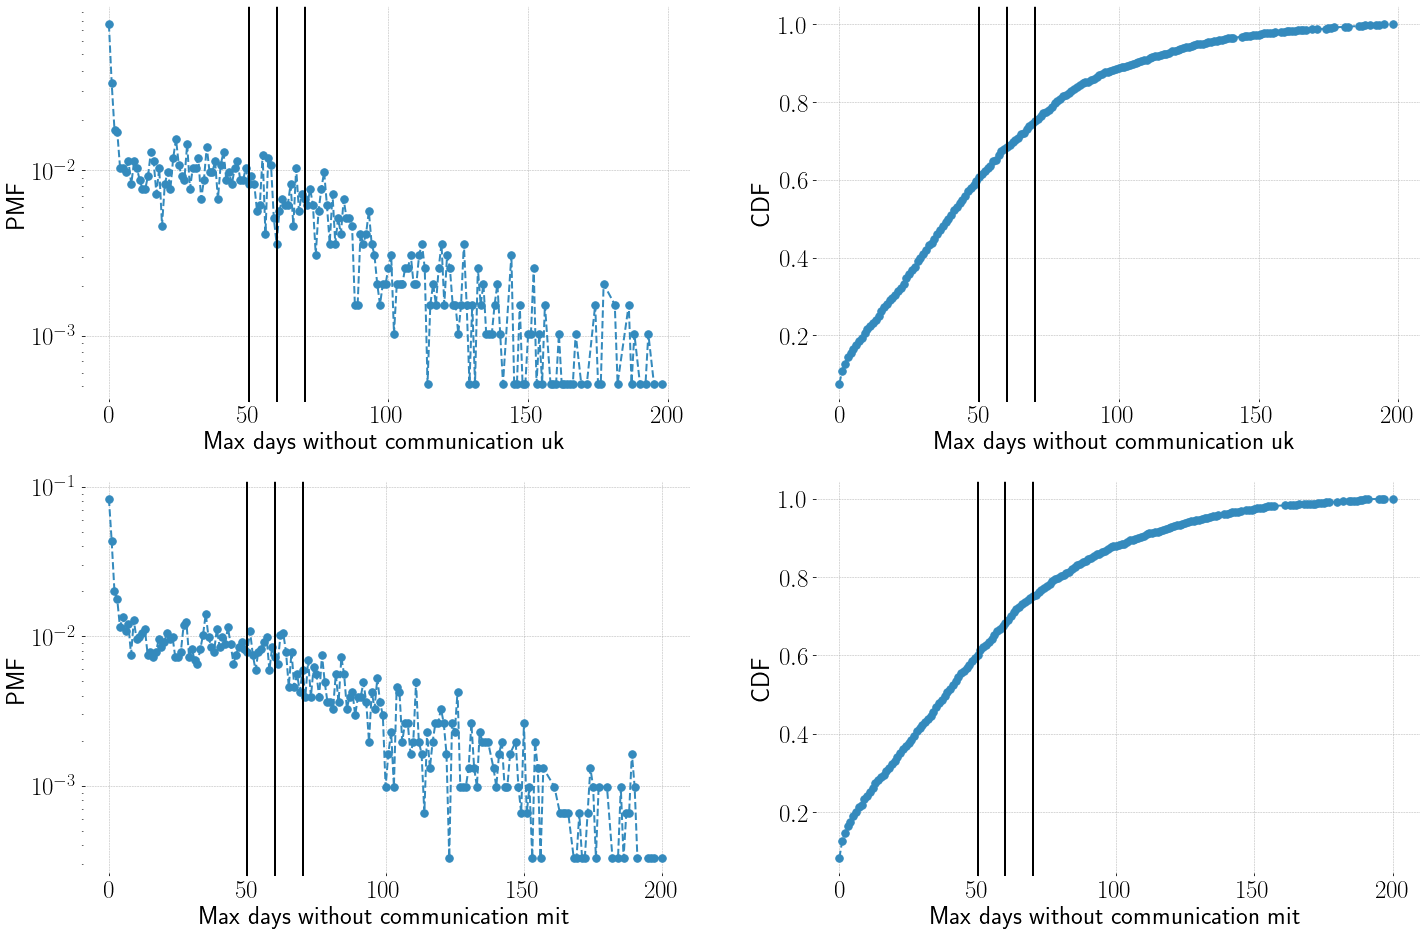

In [210]:
plt.figure(figsize=(24, 16))
for p in range(4):
    plt.subplot(2,2, p + 1)
    plt.xlabel(f"Max days without communication {['uk', 'mit'][p // 2]}")
    plt.ylabel(f"{['PMF', 'CDF'][p%2]}")
    df = maxieall[['uk', 'mit'][p//2]]
    if p % 2 == 0:
        plt.semilogy()
        plt.plot(df.index, df['pdf'], ".", markersize=15, ls="--")
    else:
        plt.plot(df.index, df['cdf'], ".", markersize=15, ls="--")
    for x in [50, 60, 70]:
        plt.axvline(x, color="black")

Now I'll fit a regression line from max days without communication 4 to 60

In [215]:
df = maxieall['uk']
df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
y = np.array(df1['cdf'])
x = np.array(df1.index)
x = sm.add_constant(x)

model = sm.OLS(y, x)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.904e+04
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           4.70e-85
Time:                        00:49:47   Log-Likelihood:                 222.47
No. Observations:                  57   AIC:                            -440.9
Df Residuals:                      55   BIC:                            -436.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1163      0.001     80.731      0.000       0.113       0.119
x1             0.0097      4e-05    242.983      0.000       0.010       0.010
==============================================================================
Omnibus:                        8.852   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.244
Skew:                          -0.878   Prob(JB):                       0.0162
Kurtosis:                       3.625   Cond. No.                         78.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [217]:
result.params[0]

0.11625278785156447

In [218]:
result.rsquared

0.999069309804257

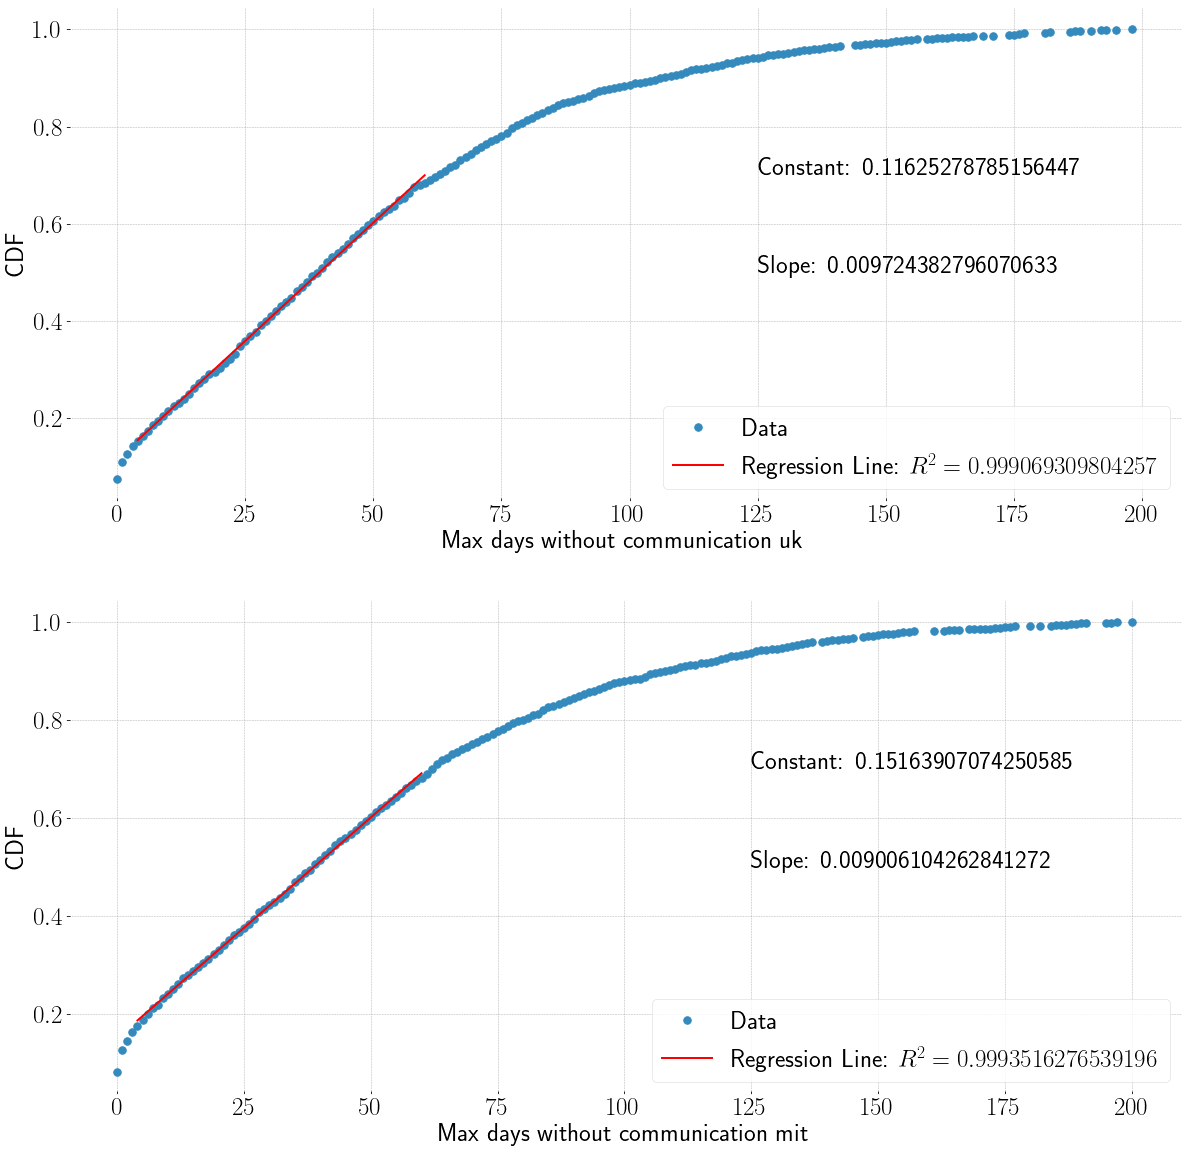

In [226]:
plt.figure(figsize=(20, 20))
p = 0
for c in ['uk', 'mit']:
    plt.subplot(2,1,p+1)
    plt.xlabel(f"Max days without communication {['uk', 'mit'][p]}")
    plt.ylabel("CDF")
    df = maxieall[c]
    plt.plot(df.index, df['cdf'], ".", markersize=15, label="Data")
    df1 = df.loc[(df.index >= 4) & (df.index <= 60)]
    y = np.array(df1['cdf'])
    x = np.array(df1.index)
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    xplot = list(df1.index)
    yplot = [result.params[0] + (X * result.params[1]) for X in xplot]
    plt.plot(xplot, yplot, marker="", ls="-", lw=2, c="red", label=fr'Regression Line: $R^2 = {result.rsquared}$')
    plt.annotate(f'Constant: {result.params[0]}', (125, 0.7), fontsize=25)
    plt.annotate(f'Slope: {result.params[1]}', (125, 0.5), fontsize=25)
    plt.legend()
    p += 1

In [199]:
maxieall = {}
for c in ['uk1', 'uk2']:
    H = {}
    df = filt_pairs[c]
    for d in df['ie_max']:
        H[d] = H.get(d, 0) + 1
    maxieall[c] = pd.DataFrame.from_dict(H, orient='index').sort_index()

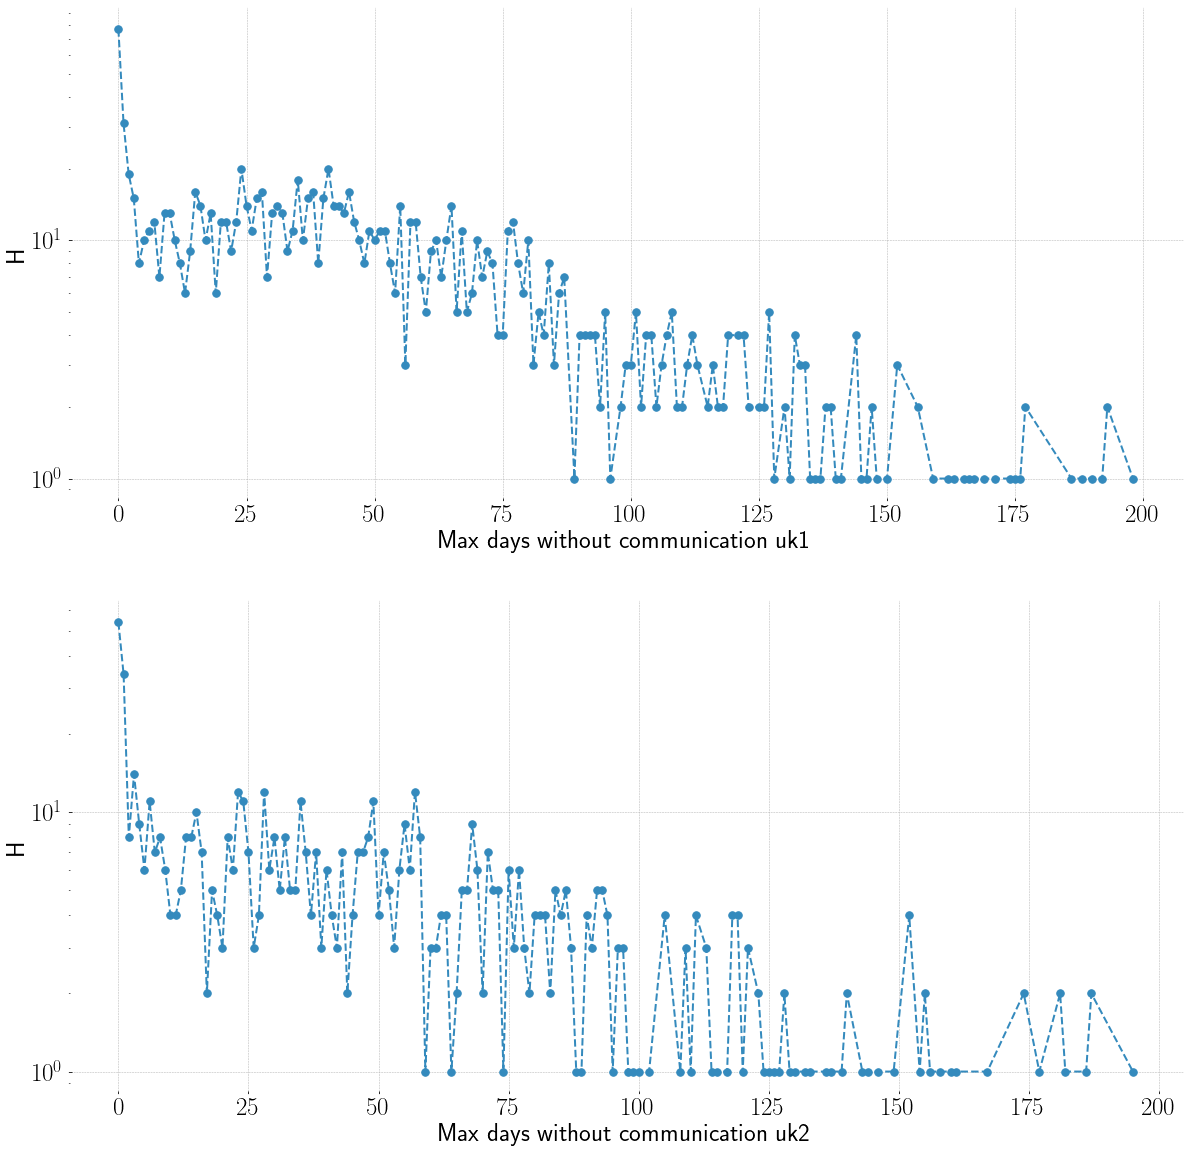

In [200]:
plt.figure(figsize=(20, 20))
p = 1
for c in maxieall.keys():
    plt.subplot(2, 1, p)
    plt.xlabel(f"Max days without communication {c}")
    plt.ylabel("H")
    plt.semilogy()
    plt.plot(maxieall[c].index, maxieall[c][0], ".", markersize=15, ls="--")
    p += 1